In [162]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.cluster import AgglomerativeClustering, KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score

## Hierarchal clustering that starts with each point as a cluster and tries to merge them 
# Load training data
data = np.load(r'C:\Users\ishit\Downloads\species_data\species\species_train.npz')
train_locs = data['train_locs']  # 2D array of lat/long
train_ids = data['train_ids']  # 1D array of species IDs

# Combine locations and IDs into a DataFrame
df_train = pd.DataFrame(train_locs, columns=['latitude', 'longitude'])
df_train['species_id'] = train_ids


In [158]:
# Create a presence-absence matrix
presence_absence = df_train.pivot_table(index=['latitude', 'longitude'], 
                                         columns='species_id', 
                                         aggfunc='size', 
                                         fill_value=0)
presence_absence[presence_absence > 0] = 1  # Convert counts to presence/absence (1 or 0)

# Calculate co-occurrence matrix
co_occurrence = np.dot(presence_absence.T, presence_absence)
co_occurrence_df = pd.DataFrame(co_occurrence, 
                                 index=presence_absence.columns, 
                                 columns=presence_absence.columns)

# Normalize matrix
co_occurrence_df = co_occurrence_df.div(co_occurrence_df.sum(axis=1), axis=0)


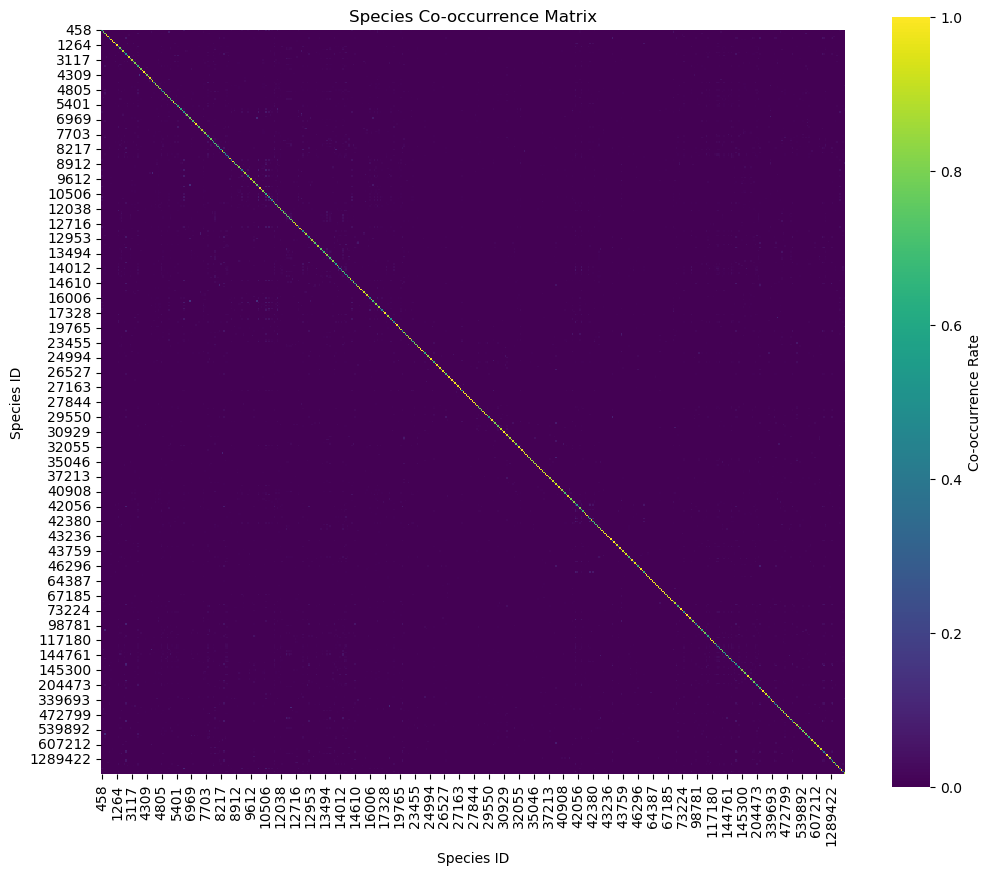

In [159]:
# Plotting co-occurence
plt.figure(figsize=(12, 10))
sns.heatmap(co_occurrence_df, cmap='viridis', square=True, cbar_kws={'label': 'Co-occurrence Rate'})
plt.title('Species Co-occurrence Matrix')
plt.xlabel('Species ID')
plt.ylabel('Species ID')
plt.show()


C:\Users\ishit\anaconda3\Lib\site-packages\seaborn\matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
C:\Users\ishit\anaconda3\Lib\site-packages\seaborn\matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


<Figure size 1200x1000 with 0 Axes>

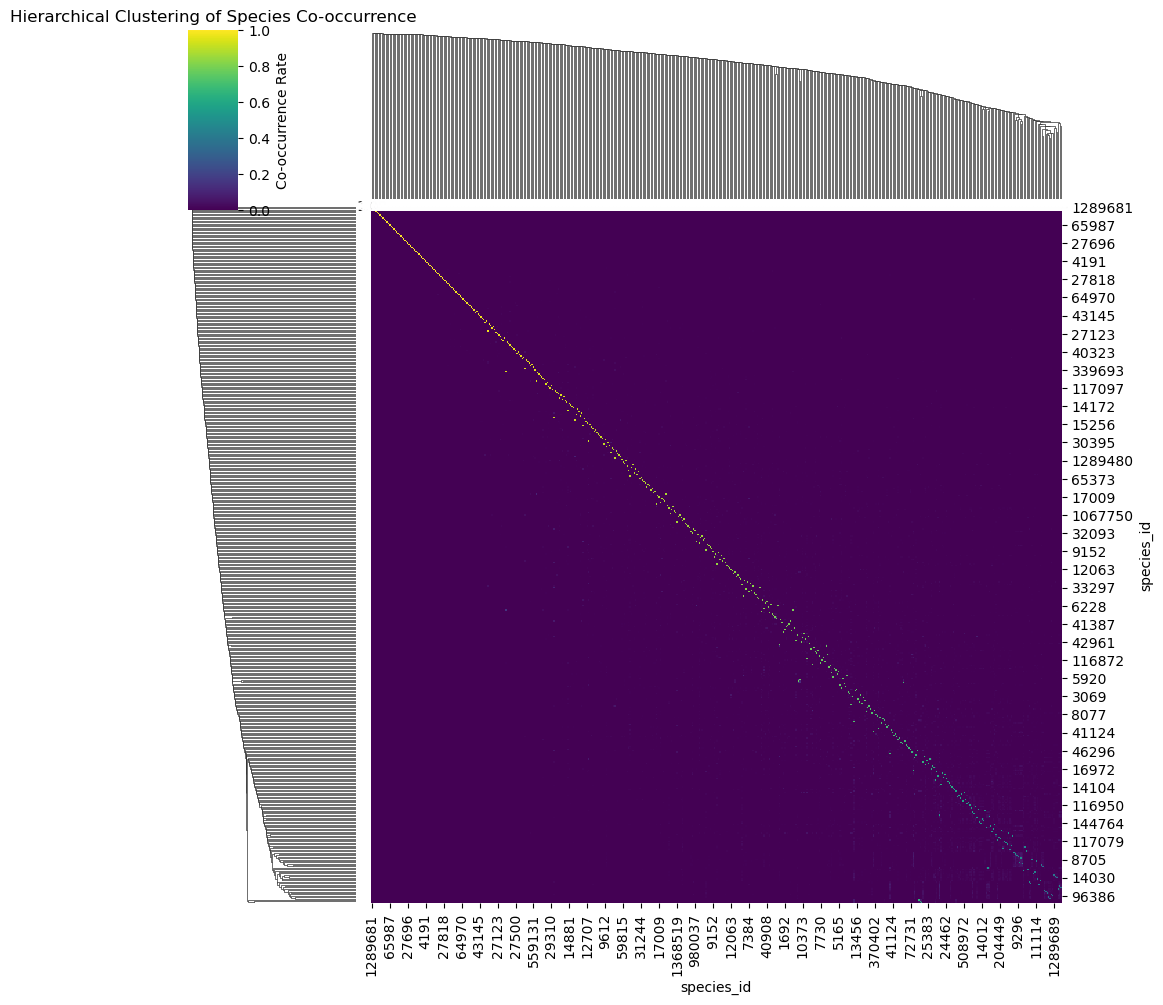

Cluster 0:


TypeError: sequence item 0: expected str instance, int found

In [160]:
# Perform hierarchical clustering on the matrix
clustering = AgglomerativeClustering(n_clusters=10)  # This is where my laptop died, so we do 10
clusters = clustering.fit_predict(co_occurrence_df)

# Add cluster labels
co_occurrence_df['Cluster'] = clusters

# Visualize clusters 
plt.figure(figsize=(12, 10))
sns.clustermap(co_occurrence_df.drop(columns='Cluster'), 
                cmap='viridis', 
                figsize=(10, 10), 
                row_cluster=True, 
                col_cluster=True, 
                cbar_kws={'label': 'Co-occurrence Rate'},
                annot=True, 
                fmt=".2f")
plt.title('Hierarchical Clustering of Species Co-occurrence')
plt.show()


co_occurrence_df = co_occurrence_df.reset_index()  
co_occurrence_df.rename(columns={'index': 'species_id'}, inplace=True)  

# Group by Cluster
species_in_clusters = co_occurrence_df.groupby('Cluster')['species_id'].apply(list)

# Display species in each cluster
for cluster, species_list in species_in_clusters.items():
    print(f"Cluster {cluster}:")
    print(", ".join(species_list))  # Print all species in the current cluster
    print("\n")  


C:\Users\ishit\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


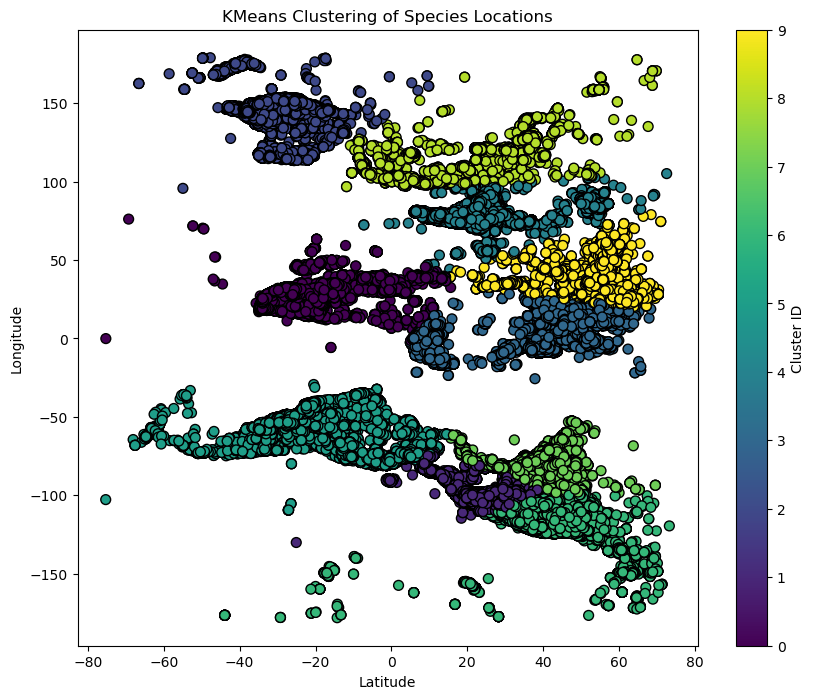

In [172]:


# Set the number of clusters for KMeans
n_clusters = 10  ##Ten is where laptop death

# Perform KMeans clustering
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
kmeans_labels = kmeans.fit_predict(train_locs)

# Combine species IDs with their cluster labels
labeled_data = np.column_stack((train_ids, kmeans_labels))

# Create a dictionary to store species in each cluster
clusters_contents = {i: [] for i in range(n_clusters)}


# Visualize clusters 
plt.figure(figsize=(10, 8))
plt.scatter(train_locs[:, 0], train_locs[:, 1], c=kmeans_labels, cmap='viridis', marker='o', s=50, edgecolor='k')
plt.xlabel("Latitude")
plt.ylabel("Longitude")
plt.title("KMeans Clustering of Species Locations")
plt.colorbar(label='Cluster ID')
plt.show()


In [ ]:
##This cell takes ages to run so its a wip, just adding it to the notebook regarless
# Elbow Method to determine the optimal number of clusters
inertia = []
silhouette_scores = []
n_clusters_range = range(2, 21)  # Adjust the range for the number of clusters

for n_clusters in n_clusters_range:
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    kmeans.fit(train_locs)
    
    inertia.append(kmeans.inertia_)  # Sum of squared distances to closest cluster center
    labels = kmeans.labels_
    
    # Calculate silhouette score
    if n_clusters > 1:  # Silhouette score is not defined for 1 cluster
        score = silhouette_score(train_locs, labels)
        silhouette_scores.append(score)
    else:
        silhouette_scores.append(0)

# Plot Elbow Curve
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.plot(n_clusters_range, inertia, marker='o')
plt.title('Elbow Method for Optimal Number of Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia (Sum of Squared Distances)')

# Plot Silhouette Score
plt.subplot(1, 2, 2)
plt.plot(n_clusters_range[1:], silhouette_scores[1:], marker='o')  # Skip the first index for silhouette scores
plt.title('Silhouette Score for Optimal Number of Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')

plt.tight_layout()
plt.show()


C:\Users\ishit\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
